# 사례를 통해서 배우는 파생 변수 만들기 1편

## 실습 개요

사례를 통해서 배우는 파생 변수 만들기 1편


1) 실습 목적
 * 실제 주가 데이터셋(OHLCV)을 통해서 파생 변수를 만들어 보는 실습을 진행합니다.
 * 금융 & 주식 도메인에서의 전문적인 파생 변수를 알아봅니다.


2) 수강 목표
 * 금융 & 주식 도메인에서의 파생 변수인 이동평균, 볼린저 밴드, MACD 등을 이해할 수 있습니다.
 * 파생 변수가 알고리즘 모델에 미치는 영향을 이해할 수 있습니다.


### 실습 목차
* **1. 주가(OHLCV) 데이터셋 실습 해보기**
  * 실습 데이터 재구성하기
  * 시계열 데이터란?
  * 파생 변수 만들기I (도메인 지식 기반)
  * 파생 변수 만들기II (상장법인정보 기반)
  * 데이터 인코딩 및 결측치 정리


###  데이터셋 개요

* 데이터셋: Yahoo Finance OHLCV 데이터셋이란? (Open High Close Low Volume)
* 데이터셋 개요 : **Yahoo Finance는 주식, 환율과 같은 금융 정보를 제공하는 플랫폼입니다.** 주식과 관련된 정보 및 시각화 정보를 웹사이트를 통해서 제공 (NASDAQ, KOSPI, NIKKEI 등) 됩니다. 데이터는 무료로 사용할 수 있으며, API를 제공하여 손쉽게 데이터를 수집 가능합니다. 또한, Yahoo Finance 정보를 랩핑한 yfinance 패키지를 이용해 파이썬에서도 사용 가능합니다.
  - (O)pen (시가): 주식의 거래가 시작된 가격을 나타냅니다. 시장이 열리면 처음으로 발생한 거래의 가격입니다.
  - (H)igh (고가): 특정 기간 동안 주식의 가격 중 최고점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 높게 거래되었는지를 보여줍니다.
  - (C)lose (종가): 주식의 거래가 마감된 가격을 나타냅니다. 시장이 닫힐 때 주식이 어떤 가격으로 거래를 마쳤는지를 보여줍니다.
  - (L)ow (저가): 특정 기간 동안 주식의 가격 중 최저점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 낮게 거래되었는지를 보여줍니다.
  - (V)Volume (거래량):  특정 기간 동안 거래된 주식의 총 수량을 나타냅니다. 거래량은 주식 시장에서 매우 중요한 지표 중 하나이며, 주식의 유동성과 관련이 있습니다. 더 높은 거래량은 주식 시장의 활발한 거래를 나타낼 수 있습니다.
  - Change (변동률): 이전 주가와 비교해 변화된 변동률 입니다.
  - code (종목 코드): 종목(회사)를 구분하는 코드입니다.
* 데이터셋 저작권 : Apache Software License (Apache)

### 환경 설정
- **패키지 설치 및 임포트**


In [2]:
!pip install mplfinance==0.12.10b0
!pip install gdown==4.7.1

In [3]:
# 계산
import numpy as np

# 전처리
from sklearn.preprocessing import LabelEncoder

# 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 출력 및 시각화
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import seaborn as sns

from IPython.display import display
from mplfinance.original_flavor import candlestick_ohlc

# 데이터셋 로드 및 정제
import gdown
import pandas as pd

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

## 1. 주가(OHLCV) 데이터셋 실습 해보기

```
💡 목차 개요 : 실제 주가 데이터셋을 통해 파생 변수를 제작해보고, 직접 알고리즘 모델로 학습을 진행합니다.  
```
- **1-1 실습 데이터 재구성하기**
- **1-2 시계열 데이터란?**
- **1-3 파생 변수 만들기I (도메인 지식 기반)**
- **1-4 파생 변수 만들기II (상장법인정보 기반)**
- **1-5 데이터 인코딩 및 결측치 정리**


### 1-1 실습 데이터 재구성하기



#### 📝 설명 : (1-1)
> OHLCV 데이터셋의 크기가 방대하고, 학습 모델에 적절치 않기 때문에 실습전에 데이터셋을 재구성 하도록 하겠습니다.
1. **OHLCV 데이터셋의 날짜 범위를 2020년 1월에서 2023년 7월 사이로 축소하도록 하겠습니다.**
2. **실습을 위해서는 정답(레이블) 컬럼을 구성해야합니다. 다음날 종가(Close)를 정답 컬럼으로 만들겠습니다.**

#### 👨‍💻 코드 : (1-1)


In [9]:
# OHLCV 데이터셋 불러오기
file_path = "/Users/myeongjinlee/Desktop/UPSTAGE AI/ml advanced"
OHCLV_file = "[ML Advanced] 실습용 데이터 셋 - OHCLV.parquet"

OHLCV_data = pd.read_parquet(f"{file_path}/{OHCLV_file}")

# 날짜는 데이터셋의 index로 되어 있습니다.
# .loc을 통해서 날짜 범위를 지정해줍시다.
OHLCV_data = OHLCV_data.sort_index()
OHLCV_data = OHLCV_data.loc["2020-01-01":"2023-07-31"]

# 상장법인정보 파일도 불러오도록 하겠습니다.
company_file = "[ML Advanced] 실습용 데이터 셋 - Company.parquet"
company_data =  pd.read_parquet(f"{file_path}/{company_file}")

In [12]:
# OHLCV 데이터셋
display(OHLCV_data)

,Open,High,Low,Close,Volume,Change,code,Date
0,7037.0,7123.0,7018.0,7106.0,13986.0,0.009518,001530,2020-01-02
1,31400.0,32350.0,31100.0,32100.0,75206.0,0.033816,003350,2020-01-02
2,7300.0,7450.0,7270.0,7340.0,60800.0,0.009629,005870,2020-01-02
3,1165.0,1180.0,1160.0,1175.0,117291.0,0.008584,006340,2020-01-02
4,95100.0,95200.0,91800.0,91900.0,250460.0,-0.035677,010950,2020-01-02
...,...,...,...,...,...,...,...,...
827854,22150.0,23600.0,22150.0,22700.0,154696.0,0.024831,000500,2023-07-31
827855,5840.0,5980.0,5790.0,5840.0,84389.0,0.001715,012630,2023-07-31
827856,34500.0,36450.0,34500.0,35850.0,192901.0,0.028694,336370,2023-07-31
827857,1154.0,1185.0,1132.0,1157.0,247674.0,0.003469,006200,2023-07-31


In [11]:
# 현재 데이터프레임의 인덱스가 날짜로 되어있습니다.
# 분석 편의를 위해서 Date컬럼을 새로 만들고, 인덱스는 새로 초기화 하겠습니다.
OHLCV_data["Date"] = OHLCV_data.index
OHLCV_data.reset_index(drop=True, inplace=True)

display(OHLCV_data)

,Open,High,Low,Close,Volume,Change,code,Date
0,7037.0,7123.0,7018.0,7106.0,13986.0,0.009518,001530,2020-01-02
1,31400.0,32350.0,31100.0,32100.0,75206.0,0.033816,003350,2020-01-02
2,7300.0,7450.0,7270.0,7340.0,60800.0,0.009629,005870,2020-01-02
3,1165.0,1180.0,1160.0,1175.0,117291.0,0.008584,006340,2020-01-02
4,95100.0,95200.0,91800.0,91900.0,250460.0,-0.035677,010950,2020-01-02
...,...,...,...,...,...,...,...,...
827854,22150.0,23600.0,22150.0,22700.0,154696.0,0.024831,000500,2023-07-31
827855,5840.0,5980.0,5790.0,5840.0,84389.0,0.001715,012630,2023-07-31
827856,34500.0,36450.0,34500.0,35850.0,192901.0,0.028694,336370,2023-07-31
827857,1154.0,1185.0,1132.0,1157.0,247674.0,0.003469,006200,2023-07-31


In [15]:
# 상장법인정보 데이터셋
display(company_data)

,company,code,industry,products,listing_date,closing_month,region
0,시지트로닉스,429270,반도체 제조업,특화반도체 소자,2023-08-03,12월,전라북도
1,에피바이오텍,446440,자연과학 및 공학 연구개발업,탈모 치료제,2023-07-31,12월,인천광역시
2,조선내화,462520,"내화, 비내화 요업제품 제조업",내화 요업제품,2023-07-28,12월,전라남도
3,에이엘티,172670,반도체 제조업,반도체 테스트 및 패키징(반도체 후공정),2023-07-27,12월,충청북도
4,유안타제14호스팩,450940,금융 지원 서비스업,금융 지원 서비스,2023-07-27,12월,서울특별시
...,...,...,...,...,...,...,...
2617,유한양행,000100,의약품 제조업,"의약품(삐콤씨, 안티푸라민, 렉라자, 로수바미브, 코푸시럽 등), 생활용품(유한락스...",1962-11-01,12월,서울특별시
2618,CJ대한통운,000120,도로 화물 운송업,"Contract Logistics, 포워딩, 항만하역, 해운, 택배국제특송, SCM...",1956-07-02,12월,서울특별시
2619,경방,000050,종합 소매업,"섬유류(면사,면혼방사,면직물,면혼방직물,화섬사,화섬직물) 제조,도매,수출입",1956-03-03,12월,서울특별시
2620,유수홀딩스,000700,회사 본부 및 경영 컨설팅 서비스업,지주사업,1956-03-03,12월,서울특별시


In [14]:
# 두 파일을 결합시켜 OHCLV와 상장법인정보를 함께 볼수 있도록 하겠습니다.
OHLCV_data = pd.merge(OHLCV_data, company_data, on="code", how="inner")
display(OHLCV_data)

,Open,High,Low,Close,Volume,Change,code,Date,company,industry,products,listing_date,closing_month,region
0,7037.0,7123.0,7018.0,7106.0,13986.0,0.009518,001530,2020-01-02,디아이동일,상품 중개업,"면사,화섬사,면포,혼방포,스포츠웨어용 신합섬 제조,도매,수출",1964-01-04,12월,서울특별시
1,7104.0,7133.0,6971.0,7077.0,36767.0,-0.004081,001530,2020-01-03,디아이동일,상품 중개업,"면사,화섬사,면포,혼방포,스포츠웨어용 신합섬 제조,도매,수출",1964-01-04,12월,서울특별시
2,7076.0,7190.0,7057.0,7143.0,67664.0,0.009326,001530,2020-01-06,디아이동일,상품 중개업,"면사,화섬사,면포,혼방포,스포츠웨어용 신합섬 제조,도매,수출",1964-01-04,12월,서울특별시
3,7143.0,7589.0,7143.0,7219.0,25473.0,0.010640,001530,2020-01-07,디아이동일,상품 중개업,"면사,화섬사,면포,혼방포,스포츠웨어용 신합섬 제조,도매,수출",1964-01-04,12월,서울특별시
4,7218.0,7341.0,7057.0,7172.0,69960.0,-0.006511,001530,2020-01-08,디아이동일,상품 중개업,"면사,화섬사,면포,혼방포,스포츠웨어용 신합섬 제조,도매,수출",1964-01-04,12월,서울특별시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714586,8100.0,8640.0,8100.0,8500.0,396245.0,0.048089,460860,2023-07-27,동국제강,1차 철강 제조업,"봉강,형강,후판,냉연강판,칼라강판",2023-06-16,12월,서울특별시
714587,8530.0,9940.0,8200.0,9940.0,1605657.0,0.169412,460860,2023-07-28,동국제강,1차 철강 제조업,"봉강,형강,후판,냉연강판,칼라강판",2023-06-16,12월,서울특별시
714588,12000.0,12920.0,11000.0,12920.0,8086428.0,0.299799,460860,2023-07-31,동국제강,1차 철강 제조업,"봉강,형강,후판,냉연강판,칼라강판",2023-06-16,12월,서울특별시
714589,42400.0,53700.0,29700.0,30000.0,2897986.0,NaN,462520,2023-07-28,조선내화,"내화, 비내화 요업제품 제조업",내화 요업제품,2023-07-28,12월,전라남도


In [16]:
# 컬럼이 너무 많아 데이터프레임 출력이 불편하니, 불필요한 컬럼을 제외하는 함수를 하나 만들겠습니다.
except_cols = ["industry", "products", "listing_date", "closing_month", "region"]
def get_display_cols(except_cols):
    return [col for col in OHLCV_data.columns if col not in except_cols]

display_cols = get_display_cols(except_cols)

In [17]:
# 이번 강의에서는 파생 변수를 제작하는 것 외에도,
# 다음날 종가(Close)를 예측하기 위한 정답(Target)값도 제작할거에요.
# 종목(code)로 집계 후 다음날 종가(Close)를 Target 변수에 삽입하도록 하겠습니다.
OHLCV_data["Target"] = OHLCV_data.groupby("code")["Close"].shift(-1)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company
0,7037.0,7123.0,7018.0,7106.0,13986.0,0.009518,001530,2020-01-02,디아이동일
1,7104.0,7133.0,6971.0,7077.0,36767.0,-0.004081,001530,2020-01-03,디아이동일
2,7076.0,7190.0,7057.0,7143.0,67664.0,0.009326,001530,2020-01-06,디아이동일
3,7143.0,7589.0,7143.0,7219.0,25473.0,0.010640,001530,2020-01-07,디아이동일
4,7218.0,7341.0,7057.0,7172.0,69960.0,-0.006511,001530,2020-01-08,디아이동일
...,...,...,...,...,...,...,...,...,...
714586,8100.0,8640.0,8100.0,8500.0,396245.0,0.048089,460860,2023-07-27,동국제강
714587,8530.0,9940.0,8200.0,9940.0,1605657.0,0.169412,460860,2023-07-28,동국제강
714588,12000.0,12920.0,11000.0,12920.0,8086428.0,0.299799,460860,2023-07-31,동국제강
714589,42400.0,53700.0,29700.0,30000.0,2897986.0,NaN,462520,2023-07-28,조선내화


#### 📚 자료 : (1-1)

*  [Yahoo Finance](https://finance.yahoo.com/) : 주가 관련 금융 플랫폼
*  [yfinance](https://pypi.org/project/yfinance/) : Yahoo Finance 전용 Python API

### 1-2 시계열 데이터란?

> 우리가 실습할 데이터셋은 시계열 형식으로 되어 있습니다. <br>
시계열 데이터는 일정 시간이나 특정 순서에 따라서 기록된 데이터 구조입니다. <br>
시계열이라는 단어와 알맞게 시간과 많이 연관이 되어있는데요. <br>
예를 들어, 시간에 따른 기상, 실시간 센서 데이터 등과 같이 시간에 종속되어 있는 형태를 시계열 데이터라고 합니다.



#### 📝 설명 : (1-2)
> 판다스(Pandas)에서 간략하게 실습을 해보고 넘어갑시다. <br>
시계열 데이터셋을 직접 만들어보고 이를 이해할 수 있도록 합니다. <br>
2020년 01월부터 2021년 01월까지의 시계열 데이터 요소를 만들어보도록 하겠습니다.

 📖 설명 : 시계열 데이터는 아래와 같이 특정 날짜나 순서에 종속되어 값이 정해지는 형태의 데이터를 말합니다.

<center><img src='https://lh3.google.com/u/0/d/1NYwmsUx1Lv11UwCBZVHoNZ6pFR50KNKr=w1259-h864-iv1' width="500"></center>

<center>이미지) 시계열 분석의 예</center>

#### 👨‍💻 코드 : (1-2)


2020-01-01    38
2020-01-02    18
2020-01-03    41
2020-01-04    10
2020-01-05    29
              ..
2020-12-26    18
2020-12-27    10
2020-12-28    15
2020-12-29     8
2020-12-30    26
Freq: D, Length: 365, dtype: int64

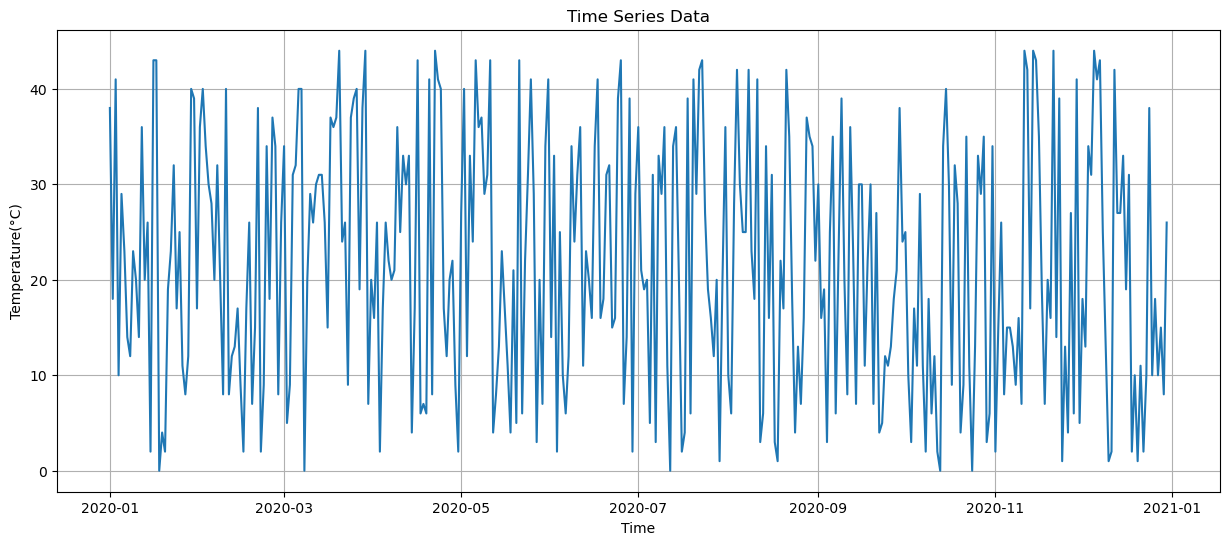

In [18]:
# 날짜 범위 생성 (예: 2020년 1월 1일부터 1년간)
dates = pd.date_range(start="2020-01-01", periods=365, freq="D")
values = np.random.randint(0, 45, size=len(dates))

# 시계열 난수 데이터 생성 (날짜를 인덱스로 설정)
time_series = pd.Series(values, index=dates)

# 생성된 시계열 데이터 출력
display(time_series)

# 시계열 데이터 시각화
plt.figure(figsize=(15, 6))
sns.lineplot(time_series)
plt.xlabel("Time")
plt.ylabel("Temperature(°C)")
plt.title("Time Series Data")
plt.grid(True)

plt.show()

#### 📚 자료 : (1-2)

*  [Time seriese - Wikipeida](https://en.wikipedia.org/wiki/Time_series) : 시계열에 대한 설명
*  [Time Series Analysis: Definition, Types, Techniques, and When It's Used
](https://www.tableau.com/learn/articles/time-series-analysis#examples) : Tableau 사이트에서 설명하는 시계열 데이터

### 1-3 파생 변수 만들기I (도메인 지식 기반)

> **파생 변수를 만들기 전에 주식에 대해서 잠깐 이야기해볼까요?** <br>
평소 주식을 많이 하시나요? 주식은 회사를 대표하는 금융 자산입니다. <br>
회사에서는 주식을 발행하여 개별(개미) 및 기관 투자자에게 판매합니다. <br> 이후, 회사로부터 발생하는 여러 이슈(적자&흑자)들이 투자자들이 가진 주식가격에 영향을 미치게 됩니다. <br>
즉, 회사가 잘되면 주가가 올라가 투자자의 투자금도 함께 상승하게 되는 원리입니다.

#### 📝 설명 : (1-3)
> 제가 앞서 주식에 대해서 먼저 이야기한 이유는 주식과 관련된 기술 및 이론을 설명하기 위함이였습니다. <br>
주식을 올바른 타이밍에 매수하고 매도하기 위해서 오랜 과거부터 여러 기술들이 발전해왔습니다.<br>
**주식을 전략적으로 분석하기 위해 사용하는 여러 기술들을 알아보고, 이를 파생 변수로 만들어보는 실습을 하겠습니다.**

 📖 설명 : 주식 시장 또는 금융 도메인에서 사용하는 여러 기술들을 간략히 알아보고 이해하도록 하겠습니다. <br>
 주식 분석에서 많이 사용하는 이동평균을 바탕으로, 볼린저 밴드(Bollinger Bands), MACD 등을 파생 변수로 추가합니다. <br>
 이외에도 일일수익률과 같은 간단한 개념도 파생 변수로 추가하도록 하겠습니다.

 **우리가 제작할 파생 변수는 아래와 같습니다.**
 - 가격 범위 (Price Range)
 - 평균 가격 (Average Price)
 - 가격 방향 (Price Direction)
 - 일일 투자 수익률 (Daily Return)
 - 이동평균 (Moving Average)
 - 볼린저 밴드 (Bollinger bands)
 - MACD (Moving Average Convergence & Divergence)




#### 👨‍💻 코드 : (1-3)
- 첫번째 파생 변수는 주가의 가격 차이 (변동폭)입니다.
- 가격 차이는 고가 (High) - 저가 (Low)로 간단히 계산할 수 있는 단일 상호작용 파생 변수 입니다.
- 가격의 변동성이 일정 수준 넘어설 때 매매 포지션을 취하는 변동성 돌파 전략 (Volatility Breakout Strategy)에 활용됩니다.
<br>
<br>
$$
가격\,차이 = 고가 - 저가
$$  

In [19]:
# 가격 차이를 구합시다.
OHLCV_data["PriceRange"] = OHLCV_data["High"] - OHLCV_data["Low"]

display_cols = get_display_cols(except_cols)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange
0,7037.0,7123.0,7018.0,7106.0,13986.0,0.009518,001530,2020-01-02,디아이동일,7077.0,105.0
1,7104.0,7133.0,6971.0,7077.0,36767.0,-0.004081,001530,2020-01-03,디아이동일,7143.0,162.0
2,7076.0,7190.0,7057.0,7143.0,67664.0,0.009326,001530,2020-01-06,디아이동일,7219.0,133.0
3,7143.0,7589.0,7143.0,7219.0,25473.0,0.010640,001530,2020-01-07,디아이동일,7172.0,446.0
4,7218.0,7341.0,7057.0,7172.0,69960.0,-0.006511,001530,2020-01-08,디아이동일,7247.0,284.0
...,...,...,...,...,...,...,...,...,...,...,...
714586,8100.0,8640.0,8100.0,8500.0,396245.0,0.048089,460860,2023-07-27,동국제강,9940.0,540.0
714587,8530.0,9940.0,8200.0,9940.0,1605657.0,0.169412,460860,2023-07-28,동국제강,12920.0,1740.0
714588,12000.0,12920.0,11000.0,12920.0,8086428.0,0.299799,460860,2023-07-31,동국제강,NaN,1920.0
714589,42400.0,53700.0,29700.0,30000.0,2897986.0,NaN,462520,2023-07-28,조선내화,39000.0,24000.0


- **다음 파생 변수는 평균 가격입니다.**
- 일 단위로 종목별 평균을 구할 수 있습니다.
- 주가의 전반적인 흐름을 이해하는데 필요한 대푯값입니다.
<br>
<br>
$$
평균 가격 = (시가 + 고가 + 저가 + 종가) / 4
$$  

In [20]:
# 종목의 대푯값인 평균 가격를 구합시다.
OHLCV_data["AveragePrice"] = (OHLCV_data["Open"] + OHLCV_data["High"] + OHLCV_data["Low"] + OHLCV_data["Close"]) / 4

display_cols = get_display_cols(except_cols)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange,AveragePrice
0,7037.0,7123.0,7018.0,7106.0,13986.0,0.009518,001530,2020-01-02,디아이동일,7077.0,105.0,7071.00
1,7104.0,7133.0,6971.0,7077.0,36767.0,-0.004081,001530,2020-01-03,디아이동일,7143.0,162.0,7071.25
2,7076.0,7190.0,7057.0,7143.0,67664.0,0.009326,001530,2020-01-06,디아이동일,7219.0,133.0,7116.50
3,7143.0,7589.0,7143.0,7219.0,25473.0,0.010640,001530,2020-01-07,디아이동일,7172.0,446.0,7273.50
4,7218.0,7341.0,7057.0,7172.0,69960.0,-0.006511,001530,2020-01-08,디아이동일,7247.0,284.0,7197.00
...,...,...,...,...,...,...,...,...,...,...,...,...
714586,8100.0,8640.0,8100.0,8500.0,396245.0,0.048089,460860,2023-07-27,동국제강,9940.0,540.0,8335.00
714587,8530.0,9940.0,8200.0,9940.0,1605657.0,0.169412,460860,2023-07-28,동국제강,12920.0,1740.0,9152.50
714588,12000.0,12920.0,11000.0,12920.0,8086428.0,0.299799,460860,2023-07-31,동국제강,NaN,1920.0,12210.00
714589,42400.0,53700.0,29700.0,30000.0,2897986.0,NaN,462520,2023-07-28,조선내화,39000.0,24000.0,38950.00


- 이번에는 주가의 방향을 구해볼까요?
- 종가(Close)가 시가(Open)에 비해 어떻게 변화되었는지 간단하게 알아 볼수 있습니다.
- 종가가 시가보다 크면 주가의 방향은 양(1)으로, 반대로 종가가 시가보다 작으면 음(-1)을 표현하도록 하겠습니다.
<br>
<br>

$$
\begin {align}
&if \; \text{종가} > \text{시가} \; \text{Then} \; 1 \\
&Else \; \text{Then} \; -1
\end {align}
$$

In [21]:
OHLCV_data['PriceDirection'] = OHLCV_data.apply(lambda row: 1 if row['Close'] > row['Open'] else -1, axis=1)

display_cols = get_display_cols(except_cols)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange,AveragePrice,PriceDirection
0,7037.0,7123.0,7018.0,7106.0,13986.0,0.009518,001530,2020-01-02,디아이동일,7077.0,105.0,7071.00,1
1,7104.0,7133.0,6971.0,7077.0,36767.0,-0.004081,001530,2020-01-03,디아이동일,7143.0,162.0,7071.25,-1
2,7076.0,7190.0,7057.0,7143.0,67664.0,0.009326,001530,2020-01-06,디아이동일,7219.0,133.0,7116.50,1
3,7143.0,7589.0,7143.0,7219.0,25473.0,0.010640,001530,2020-01-07,디아이동일,7172.0,446.0,7273.50,1
4,7218.0,7341.0,7057.0,7172.0,69960.0,-0.006511,001530,2020-01-08,디아이동일,7247.0,284.0,7197.00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
714586,8100.0,8640.0,8100.0,8500.0,396245.0,0.048089,460860,2023-07-27,동국제강,9940.0,540.0,8335.00,1
714587,8530.0,9940.0,8200.0,9940.0,1605657.0,0.169412,460860,2023-07-28,동국제강,12920.0,1740.0,9152.50,1
714588,12000.0,12920.0,11000.0,12920.0,8086428.0,0.299799,460860,2023-07-31,동국제강,NaN,1920.0,12210.00,1
714589,42400.0,53700.0,29700.0,30000.0,2897986.0,NaN,462520,2023-07-28,조선내화,39000.0,24000.0,38950.00,-1



- 주식에서 중요하게 여겨지는 개념이 "복리" 입니다.
- 주식은 복리의 마법이 존재하는 시장입니다. 일일 수익률이 지속적으로 상승한다면 투자 수익금이 기하급수적으로 올라가게 됩니다.
- 자신이 보유한 주식의 일일 수익률을 바탕으로 추후 복리를 계산해 장기적인 미래 수익률을 볼수도 있겠죠.
- 또한, 과거 특정 종목의 일일 수익률을 분석해 인사이트를 얻을 수도 있습니다.
- **파생 변수로 "일일 수익률"을 구해보도록 하겠습니다.**

$$
일일 수익률 = \left(\frac{다음날 종가-현재 종가}{현재 종가}\right) * 100
$$

<br>
<center>or</center>
<br>

$$
일일 수익률 = ((다음날 종가 - 현재 종가) - 1) * 100
$$





In [ ]:
# 일일 수익률은 두가지 방법으로 계산할 수 있습니다.
# 첫번째는 수식을 직접 명시하는 방법입니다.
display(
    ((OHLCV_data["Close"] / OHLCV_data["Close"].shift(1)) - 1) * 100
)

0              NaN
1         0.543478
2         0.000000
3         0.540541
4         1.792115
            ...   
714586    0.000000
714587    0.000000
714588    0.000000
714589    0.000000
714590    0.000000
Name: Close, Length: 714591, dtype: float64

In [ ]:
# 두번째 방법은 pct_chage 기능을 이용하는 것입니다.
# pct_chage는 행과 행사이의 차이를 구하는 기능입니다.

# 두 방법 모두 결과는 동일합니다.
OHLCV_data["DailyReturn"] = OHLCV_data["Close"].pct_change() * 100

display_cols = get_display_cols(except_cols)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange,AveragePrice,PriceDirection,DailyReturn
0,55500.0,56000.0,55000.0,55200.0,12993228.0,-0.010753,005930,2020-01-02,삼성전자,55500.0,1000.0,27825.0,-1,NaN
1,56000.0,56600.0,54900.0,55500.0,15422255.0,0.005435,005930,2020-01-03,삼성전자,55500.0,1700.0,28000.0,-1,0.543478
2,54900.0,55600.0,54600.0,55500.0,10278951.0,0.000000,005930,2020-01-06,삼성전자,55800.0,1000.0,27400.0,1,0.000000
3,55700.0,56400.0,55600.0,55800.0,10009778.0,0.005405,005930,2020-01-07,삼성전자,56800.0,800.0,27975.0,1,0.540541
4,56200.0,57400.0,55900.0,56800.0,23501171.0,0.017921,005930,2020-01-08,삼성전자,58600.0,1500.0,28175.0,1,1.792115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714586,0.0,0.0,0.0,12900.0,0.0,0.000000,008500,2023-07-25,일정실업,12900.0,0.0,-3225.0,1,0.000000
714587,0.0,0.0,0.0,12900.0,0.0,0.000000,008500,2023-07-26,일정실업,12900.0,0.0,-3225.0,1,0.000000
714588,0.0,0.0,0.0,12900.0,0.0,0.000000,008500,2023-07-27,일정실업,12900.0,0.0,-3225.0,1,0.000000
714589,0.0,0.0,0.0,12900.0,0.0,0.000000,008500,2023-07-28,일정실업,12900.0,0.0,-3225.0,1,0.000000


- **⛔ 만들고 보니 너무 쉽지않나요? 근데 이렇게 구하시면 안됩니다! ⛔**
- 종목(code)컬럼이 존재하기 때문에 종목별로 따로 집계하여 일일 수익률을 구해야합니다. 아래처럼요.

In [ ]:
OHLCV_data['DailyReturn'] = OHLCV_data.groupby('code')['Close'].transform(lambda x: x.pct_change() * 100)

- 일일 투자 수익률을 **양수인 경우에는 수익**을 의미하고, **음수인 경우에는 손실**을 나타냅니다.
- 주식 투자 시, 매번 수익을 본다면 복리가 적용되면서 엄청난 이익을 불러오겠죠?

<center><img src='https://lh3.google.com/u/0/d/1MqoPup0Nv7d7tOhN8i3ULqIDdR-j-7Ge=w1259-h864-iv1' width="450"></center>
<center>이미지) "첫 번째 규칙은 절대 잃지 마라. 두 번째 규칙은 첫 번째를 절대로 따라라." -워런 버핏-

- **다음 파생 변수는 이동평균(Moving average)입니다.**
- 주식 투자자들이 종목 분석을 진행할 때 주식 차트라는 것을 보게됩니다.
- 이때 차트에서 이동평균선을 기반으로 많이 추세를 파악합니다. 주로 이평선이라고도 불립니다.
- **이동평균을 중요시하는 이유는 주가의 전반적인 추세를 말끔하게 볼수 있다는 장점이 있습니다.**
- 또한, 이동평균을 바탕으로 파생되는 주식 분석에 중요한 여러 중요한 이론들이 존재합니다.
<br>
<br>
$$
이동평균(SMA_{n}) = \frac{종가_{1}+종가_{2}+종가_{3} +...+종가_{n}}{n}
$$
<br>
<br>
- 위의 식처럼 **이동평균은 특정 기간의 종가의 평균값을 계산한 결과입니다.**
- 이동평균은 크게 **단순 이동평균 (Simple Moving Average, SMA)**와 **지수 이동평균(Exponential Moving Average, EMA)**로 나뉩니다.
- 지수 이동평균은 뒤에서 다시 다뤄보도록 하고, 여기서는 단순 이동평균으로 파생 변수를 만들어 보겠습니다.

In [ ]:
# 이동 평균은 rolling 기능을 이용해 쉽게 구할 수 있습니다.
# rolling은 윈도우(기간)을 설정하여 특정 연산을 할수 있습니다.
# window는 몇일 간의 이동 평균을 구할지 설정하는 파라미터입니다.
display("예) 20일간의 종가 합산")
display(OHLCV_data["Close"].rolling(window=20).sum())

'예) 20일간의 종가 합산'

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
714586    258000.0
714587    258000.0
714588    258000.0
714589    258000.0
714590    258000.0
Name: Close, Length: 714591, dtype: float64

In [ ]:
# mean으로 바꿔주면 20일간의 이동평균이 됩니다.
display("20일간의 이동평균")
display(OHLCV_data["Close"].rolling(window=20).mean())

'20일간의 이동평균'

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
714586    12900.0
714587    12900.0
714588    12900.0
714589    12900.0
714590    12900.0
Name: Close, Length: 714591, dtype: float64

- 이동평균은 주로 5일, 20일, 60일, 120일로 설정하여 분석합니다.
- **보통은 5일, 20일은 "단기 이동평균", 60일은 "중기 이동평균", 120일은 "장기 이동평균"이라 합니다.**
- 중·장기 이동 평균은 단기 적인 주가에 의한 변화가 둔합니다. 이 때문에 주가의 대세를 장기적으로 판단할 수 있습니다.
- 반대로 단기 이동 평균은 시세의 전환을 빠르게 파악할 수 있으므로 주가의 약한 변동에도 민감하게 반응합니다.
- 우리는 파생 변수로 이 모든것을 만들어 보겠습니다. :)

In [ ]:
# 5일, 20일, 60일, 120일의 이동평균을 계산합니다.
OHLCV_data["MovingAverage5d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=5).mean())
OHLCV_data["MovingAverage20d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).mean())
OHLCV_data["MovingAverage60d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=60).mean())
OHLCV_data["MovingAverage120d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=120).mean())

In [ ]:
# 과거의 종가를 이용해서 이동평균을 구하기 때문에 첫 부분에는 결측치가 만들어지는 것을 볼수 있습니다.
display_cols = get_display_cols(except_cols)
display(OHLCV_data[display_cols].head(30))

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange,AveragePrice,PriceDirection,DailyReturn,MovingAverage5d,MovingAverage20d,MovingAverage60d,MovingAverage120d
0,55500.0,56000.0,55000.0,55200.0,12993228.0,-0.010753,005930,2020-01-02,삼성전자,55500.0,1000.0,27825.0,-1,NaN,NaN,NaN,NaN,NaN
1,56000.0,56600.0,54900.0,55500.0,15422255.0,0.005435,005930,2020-01-03,삼성전자,55500.0,1700.0,28000.0,-1,0.543478,NaN,NaN,NaN,NaN
2,54900.0,55600.0,54600.0,55500.0,10278951.0,0.000000,005930,2020-01-06,삼성전자,55800.0,1000.0,27400.0,1,0.000000,NaN,NaN,NaN,NaN
3,55700.0,56400.0,55600.0,55800.0,10009778.0,0.005405,005930,2020-01-07,삼성전자,56800.0,800.0,27975.0,1,0.540541,NaN,NaN,NaN,NaN
4,56200.0,57400.0,55900.0,56800.0,23501171.0,0.017921,005930,2020-01-08,삼성전자,58600.0,1500.0,28175.0,1,1.792115,55760.0,NaN,NaN,NaN
5,58400.0,58600.0,57400.0,58600.0,24102579.0,0.031690,005930,2020-01-09,삼성전자,59500.0,1200.0,28950.0,1,3.169014,56440.0,NaN,NaN,NaN
6,58800.0,59700.0,58300.0,59500.0,16000170.0,0.015358,005930,2020-01-10,삼성전자,60000.0,1400.0,29325.0,1,1.535836,57240.0,NaN,NaN,NaN
7,59600.0,60000.0,59100.0,60000.0,11359139.0,0.008403,005930,2020-01-13,삼성전자,60000.0,900.0,29675.0,1,0.840336,58140.0,NaN,NaN,NaN
8,60400.0,61000.0,59900.0,60000.0,16906295.0,0.000000,005930,2020-01-14,삼성전자,59000.0,1100.0,30325.0,-1,0.000000,58980.0,NaN,NaN,NaN
9,59500.0,59600.0,58900.0,59000.0,14300928.0,-0.016667,005930,2020-01-15,삼성전자,60700.0,700.0,29750.0,-1,-1.666667,59420.0,NaN,NaN,NaN


- **삼성전자 종목을 기준으로 이동평균선을 그려볼까요?**
- 우리 함께 직접 삼성전자 주식을 분석해봅시다.

In [ ]:
# 결측치 들이 많이 생겼기 때문에 결측치들을 모두 제거해주겠습니다.
samsung_data = OHLCV_data[OHLCV_data["code"] == "005930"].copy()
samsung_data = samsung_data[
    samsung_data["MovingAverage5d"].notnull() &
    samsung_data["MovingAverage20d"].notnull() &
    samsung_data["MovingAverage60d"].notnull() &
    samsung_data["MovingAverage120d"].notnull()
]

In [ ]:
# 오늘이 2023-03-01이라고 가정하겠습니다.
# 2023-01-01 ~ 2023-03-01까지의 데이터를 보죠.
samsung_data = samsung_data[(samsung_data["Date"] >= "2023-03-01") & (samsung_data["Date"] <= "2023-03-31")]

# 날짜 형식을 숫자로 변환해야 시각화를 하기 수월합니다.
samsung_data["Date"] = samsung_data["Date"].map(mpdates.date2num)

# 차트를 그리기 위해서 필요한 데이터만 뽑아 보아요.
samsung_data = samsung_data[
    [
        "Date",
        "Open",
        "High",
        "Low",
        "Close",
        "MovingAverage5d",
        "MovingAverage20d",
        "MovingAverage60d",
        "MovingAverage120d",
    ]
]

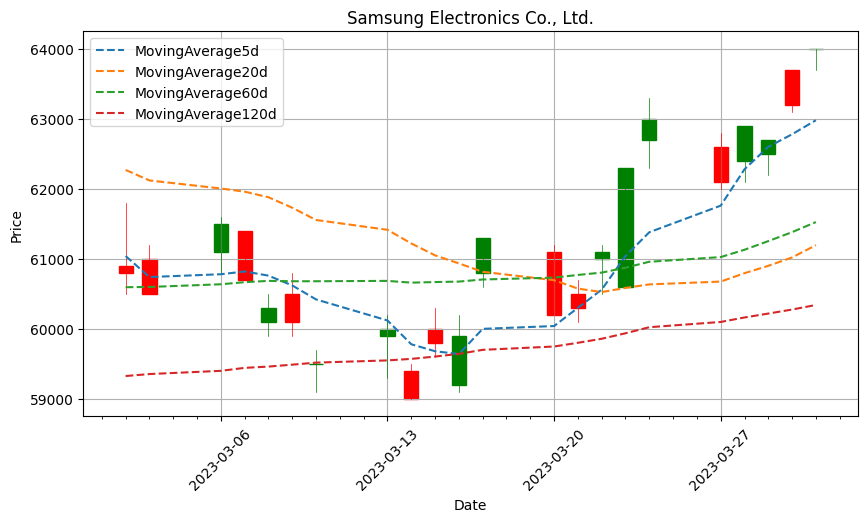

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# 아래 함수를 이용해 캔들차트를 그릴 수 있습니다.
candlestick_ohlc(ax, samsung_data.values, width=0.6, colorup="g", colordown="r")

# X 축에 주간 구분선을 추가 하겠습니다.
ax.xaxis.set_major_locator(mpdates.WeekdayLocator(mpdates.MONDAY))
ax.xaxis.set_minor_locator(mpdates.DayLocator())

# 아까 숫자로 변환한 날짜 데이터를 보기 좋게 형식 변환을 합시다.
ax.xaxis.set_major_formatter(mpdates.DateFormatter("%Y-%m-%d"))

# 반복문을 통해 이동평균선을 그려줍니다.
for col in [
    "MovingAverage5d",
    "MovingAverage20d",
    "MovingAverage60d",
    "MovingAverage120d",
]:
    ax.plot(samsung_data["Date"], samsung_data[col], label=col, linestyle="--")


# 필요한 범례들을 작성해 줍시다.
plt.title("Samsung Electronics Co., Ltd.")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()


- 이제 이동평균을 파생 변수로 만들어냈으니, 이에 기반한 여러 기술들을 제작해봅시다.
- **볼린저 밴드(Bollinger bands)는 이동평균을 기준으로 상한(Upper), 하한(Lower) 밴드를 구성하여 추세와 변동성을 파악하는 기술입니다.**
- 1980년대 후반 존 볼린저가 발명하였고, 주식 기술 분석에서 많이 활용되는 보조지표입니다.
- 일반적으로 20일 이동평균에 2배의 표준편차를 더하거나 빼서 구하게 됩니다.

<br>
<br>

$$
상단~볼린저~밴드 = 20일~이동평균 +(k \times 표준편차)
$$

<br>
<br>

$$
하단~볼린저~밴드 = 20일~이동평균 -(k \times 표준편차)
$$

<br>
<br>

- 볼린저 밴드를 계산해보고, 위의 이동평균선과 같이 차트로 만들어 보도록 하겠습니다.

In [ ]:
# 표준편차에 대한 상한 및 하한 밴드의 배수 설정
std_multiplier = 2

std = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).std())

# 상한은 일반적으로 20일 이동평균에 2배의 표준편차 더하기
# 하한은 일반적으로 20일 이동평균에 2배의 표준편차 빼기
OHLCV_data["UpperBollingerBand"] = OHLCV_data["MovingAverage20d"] + (std_multiplier * std)
OHLCV_data["LowerBollingerBand"] = OHLCV_data["MovingAverage20d"] - (std_multiplier * std)

- **아까와 동일하게 이동평균선에 볼린저 밴드를 추가해서 시각화 해보겠습니다.**
- 이동평균과 볼린저 밴드가 어떤역할을 하는지 이해해봅시다.

In [ ]:
# 결측치 들이 많이 생겼기 때문에 결측치들을 모두 제거해주겠습니다.
samsung_data = OHLCV_data[OHLCV_data["code"] == "005930"].copy()
samsung_data = samsung_data[
    samsung_data["MovingAverage5d"].notnull() &
    samsung_data["MovingAverage20d"].notnull() &
    samsung_data["MovingAverage60d"].notnull() &
    samsung_data["LowerBollingerBand"].notnull() &
    samsung_data["UpperBollingerBand"].notnull()
]

In [ ]:
# 오늘이 2023-03-01이라고 가정하겠습니다.
# 2023-01-01 ~ 2023-03-01까지의 데이터를 보죠.
samsung_data = samsung_data[(samsung_data["Date"] >= "2023-03-01") & (samsung_data["Date"] <= "2023-03-31")]

# 날짜 형식을 숫자로 변환해야 시각화를 하기 수월합니다.
samsung_data["Date"] = samsung_data["Date"].map(mpdates.date2num)

# 차트를 그리기 위해서 필요한 데이터만 뽑아 보아요.
samsung_data = samsung_data[
    [
        "Date",
        "Open",
        "High",
        "Low",
        "Close",
        "MovingAverage5d",
        "MovingAverage20d",
        "MovingAverage60d",
        "MovingAverage120d",
        "LowerBollingerBand",
        "UpperBollingerBand",
    ]
]

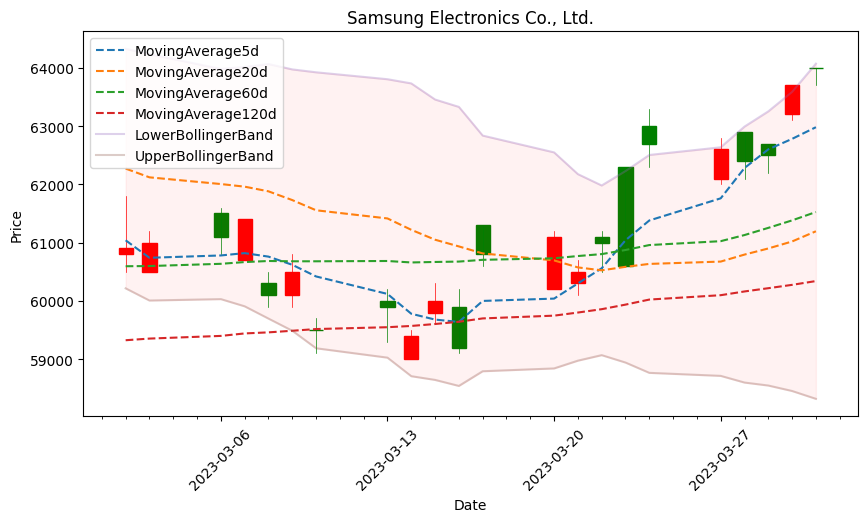

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# 아래 함수를 이용해 캔들차트를 그릴 수 있습니다.
candlestick_ohlc(ax, samsung_data.values, width=0.6, colorup="g", colordown="r")

# X 축에 주간 구분선을 추가 하겠습니다.
ax.xaxis.set_major_locator(mpdates.WeekdayLocator(mpdates.MONDAY))
ax.xaxis.set_minor_locator(mpdates.DayLocator())

# 아까 숫자로 변환한 날짜 데이터를 보기 좋게 형식 변환을 합시다.
ax.xaxis.set_major_formatter(mpdates.DateFormatter("%Y-%m-%d"))

# 반복문을 통해 이동평균선을 그려줍니다.
for col in [
    "MovingAverage5d",
    "MovingAverage20d",
    "MovingAverage60d",
    "MovingAverage120d",
]:
    ax.plot(samsung_data["Date"], samsung_data[col], label=col, linestyle="--")

for col in [
    "LowerBollingerBand",
    "UpperBollingerBand",
]:
    ax.plot(samsung_data["Date"], samsung_data[col], label=col, alpha=0.3)

# 볼린저 밴드를 위해 투명도를 가진 색을 채워놓도록 하겠습니다.
plt.fill_between(
    samsung_data["Date"],
    samsung_data["LowerBollingerBand"],
    samsung_data["UpperBollingerBand"],
    color="red",
    alpha=0.05,
)


# 필요한 범례들을 작성해 줍시다.
plt.title("Samsung Electronics Co., Ltd.")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

plt.show()


- 볼린저 밴드까지 완성하여 시각화를 하니 실제 주식 차트에서 보는 것과 유사해 보입니다.
- 볼린저 밴드의 영역이 좁으면 주가의 변동성이 낮다는 것을 의미하고, 넓으면 변동성이 높다는 것을 의미합니다.
- 이외에도 주가의 추세를 확인하는데 도움을 주는 지표이며, 아래 첨부한 관련 참고자료를 보시는 것을 추천드립니다.

- **이번엔 MACD (Moving Average Convergence & Divergence)라고 불리는 이동평균 수렴&확산 지수도 구해보겠습니다.**
- MACD도 이동평균에서 파생된 기술입니다. "엠에이씨디" 및 "맥디" 라고 발음합니다.
- 장기 지수이동평균과 단기 지수이동평균의 차이를 통해 계산됩니다.
- 주로 주가 추세의 힘과 방향성을 파악하여 매매신호를 잡으려는 목적으로 활용됩니다.
<br>
<br>
$$
MACD = 12일~지수이동평균 - 26일~지수이동평균
$$

- MACD를 계산하려면 지수 이동평균을 알아야합니다.
- 지수 이동평균(Exponential Moving Average, EMA)은 시계열 데이터에서 최근 관측치에 높은 가중치를 주고, 과거 관측치에는 낮은 가중치를 주어 이동평균을 차등 계산하는 방식입니다.
- 12일 & 26일 지수 이동평균도 파생 변수로 함께 추가하도록 하죠.
<br>
<br>
$$
EMA_{t} = \alpha \times Close_{t} + (1 - \alpha) \times EMA_{t-1}
$$


In [ ]:
# .ewm를 이용하면 데이터프레임에서 지수가중함수를 손쉽게 제어할 수 있습니다.
# 12일, 26일 각각의 지수가중함수를 구하도록 하겠습니다.
OHLCV_data['ShortEMA'] = OHLCV_data["Close"].ewm(span=12, adjust=False).mean()
OHLCV_data['LongEMA'] = OHLCV_data["Close"].ewm(span=26, adjust=False).mean()

# 지수가중함수의 차를 구해 MACD를 완성 시킵니다.
OHLCV_data['MACD'] = OHLCV_data['ShortEMA'] - OHLCV_data['LongEMA']

- 원래 주식의 기술 분석에서는 MACD와 함께 신호(Signal)값을 추가하여 분석을 해야합니다.
- 하지만 이번 실습에서는 MACD만을 파생 변수로 사용하도록 하겠습니다.
- 더 깊은 정보를 원하신다면 아래 자료를 참고해주세요.


In [ ]:
# 짜잔! 도메인 지식에 기반한 여러 파생 변수들이 만들어졌습니다!
display_cols = get_display_cols(except_cols)

display(OHLCV_data[display_cols].head(10))

display(display_cols)

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,...,DailyReturn,MovingAverage5d,MovingAverage20d,MovingAverage60d,MovingAverage120d,LowerBollingerBand,UpperBollingerBand,ShortEMA,LongEMA,MACD
0,55500.0,56000.0,55000.0,55200.0,12993228.0,-0.010753,005930,2020-01-02,삼성전자,55500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55200.000000,55200.000000,0.000000
1,56000.0,56600.0,54900.0,55500.0,15422255.0,0.005435,005930,2020-01-03,삼성전자,55500.0,...,0.543478,NaN,NaN,NaN,NaN,NaN,NaN,55246.153846,55222.222222,23.931624
2,54900.0,55600.0,54600.0,55500.0,10278951.0,0.000000,005930,2020-01-06,삼성전자,55800.0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,55285.207101,55242.798354,42.408747
3,55700.0,56400.0,55600.0,55800.0,10009778.0,0.005405,005930,2020-01-07,삼성전자,56800.0,...,0.540541,NaN,NaN,NaN,NaN,NaN,NaN,55364.406008,55284.072550,80.333458
4,56200.0,57400.0,55900.0,56800.0,23501171.0,0.017921,005930,2020-01-08,삼성전자,58600.0,...,1.792115,55760.0,NaN,NaN,NaN,NaN,NaN,55585.266622,55396.363472,188.903150
5,58400.0,58600.0,57400.0,58600.0,24102579.0,0.031690,005930,2020-01-09,삼성전자,59500.0,...,3.169014,56440.0,NaN,NaN,NaN,NaN,NaN,56049.071757,55633.669882,415.401876
6,58800.0,59700.0,58300.0,59500.0,16000170.0,0.015358,005930,2020-01-10,삼성전자,60000.0,...,1.535836,57240.0,NaN,NaN,NaN,NaN,NaN,56579.983795,55920.064705,659.919089
7,59600.0,60000.0,59100.0,60000.0,11359139.0,0.008403,005930,2020-01-13,삼성전자,60000.0,...,0.840336,58140.0,NaN,NaN,NaN,NaN,NaN,57106.140134,56222.282134,883.858000
8,60400.0,61000.0,59900.0,60000.0,16906295.0,0.000000,005930,2020-01-14,삼성전자,59000.0,...,0.000000,58980.0,NaN,NaN,NaN,NaN,NaN,57551.349344,56502.113087,1049.236257
9,59500.0,59600.0,58900.0,59000.0,14300928.0,-0.016667,005930,2020-01-15,삼성전자,60700.0,...,-1.666667,59420.0,NaN,NaN,NaN,NaN,NaN,57774.218676,56687.141748,1087.076928


['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Change',
 'code',
 'Date',
 'company',
 'Target',
 'PriceRange',
 'AveragePrice',
 'PriceDirection',
 'DailyReturn',
 'MovingAverage5d',
 'MovingAverage20d',
 'MovingAverage60d',
 'MovingAverage120d',
 'LowerBollingerBand',
 'UpperBollingerBand',
 'ShortEMA',
 'LongEMA',
 'MACD']

#### 📚 자료 : (1-3)

*  [주식의 기원, 유래, 기본원리](https://m.blog.naver.com/chochila/40149313237
) : 주식 기본 설명
*  [주식 단어 모음집](https://blog.hyosung.com/5006) : 주식 기초 단어 익히기
*  [이동평균선의 이해](https://www.hi-ib.com/systemtrade/st02090602.jsp) : 이동평균선을 이해하고 이에따른 투자전략을 세우는 자료
*  [볼린저 밴드의 이해](https://m.blog.naver.com/rmsgud2007/222316784405) : 볼린저 밴드를 깊게 이해할 수 있는 자료
*  [MACD 위키백과](https://namu.wiki/w/MACD) : MACD 설명 자료
*  [지수가중함수](https://wikidocs.net/152787) : Pandas의 지수가중함수에 대해 설명



### 1-4 파생 변수 만들기II (상장법인정보 기반)

> **도메인 지식에 기반해서 파생 변수를 만들어봤으니 이번에는 상장법인정보를 기반해 파생 변수도 만들어볼게요!**<br>
- 상장법인정보에는 **업종(industry), 주요 제품(Products), 상장일(listing_date), 결산월(closing_month), 지역(region)**이 존재합니다.

#### 📝 설명 : (1-4)
> 이번 파생 변수 만들기 II에서는 크게 2가지의 파생 변수를 만들겠습니다. <br>
**"통계 기반 파생 변수"와 "시간관련 파생 변수"**는 도메인 지식과 관련된 변수라기 보다는 기존의 변수를 분할하거나 계산하여 제작할 수 있습니다. <br>
도메인 지식과 연관되어 있지 않아 어렵지 않으니 잘 따라와보세요!

#### 👨‍💻 코드 : (1-4)
- 통계 기반 파생 변수는 변수들의 통계값을 이용해 제작하게 됩니다.
- 주로 대푯값을 이용하기 때문에 관측값의 상대적 위치를 잘 파악할 수 있는 장점이 있습니다.
- **업종(industry)을 기준으로 Open (시가), High (고가), Low (저가), Close (종가), Volume (거래량) 컬럼의 일별 평균과 중앙값을 파생 변수로 추가할게요!**

In [ ]:
# 상장법인정보를 기반해 파생 변수를 만들어보죠!
# 아까 제작한 도메인 지식 기반 파생 변수는 출력하지 않을게요.
except_cols = [
    "DailyReturn", "MovingAverage5d", "MovingAverage20d",
    "MovingAverage60d", "MovingAverage120d", "LowerBollingerBand",
    "UpperBollingerBand", "ShortEMA", "LongEMA", "MACD", "code",
    "PriceRange", "AveragePrice", "PriceDirection", "products"
]
display_cols = get_display_cols(except_cols)

OHLCV_data[display_cols].head(10)

,Open,High,Low,Close,Volume,Change,Date,company,industry,listing_date,closing_month,region,Target
0,55500.0,56000.0,55000.0,55200.0,12993228.0,-0.010753,2020-01-02,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,55500.0
1,56000.0,56600.0,54900.0,55500.0,15422255.0,0.005435,2020-01-03,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,55500.0
2,54900.0,55600.0,54600.0,55500.0,10278951.0,0.000000,2020-01-06,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,55800.0
3,55700.0,56400.0,55600.0,55800.0,10009778.0,0.005405,2020-01-07,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,56800.0
4,56200.0,57400.0,55900.0,56800.0,23501171.0,0.017921,2020-01-08,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,58600.0
5,58400.0,58600.0,57400.0,58600.0,24102579.0,0.031690,2020-01-09,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,59500.0
6,58800.0,59700.0,58300.0,59500.0,16000170.0,0.015358,2020-01-10,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,60000.0
7,59600.0,60000.0,59100.0,60000.0,11359139.0,0.008403,2020-01-13,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,60000.0
8,60400.0,61000.0,59900.0,60000.0,16906295.0,0.000000,2020-01-14,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,59000.0
9,59500.0,59600.0,58900.0,59000.0,14300928.0,-0.016667,2020-01-15,삼성전자,통신 및 방송 장비 제조업,1975-06-11,12월,경기도,60700.0


In [ ]:
# OHLCV컬럼 모두 업종별로 일일 평균, 중앙값을 집계해보겠습니다.
# 일별, 업종별로 집계를 해야하기 때문에 두개의 변수(Date, industry)가 집계요소로 들어갑니다.

# 일별 시가의 평균, 중앙값
open_stats = OHLCV_data.groupby(["Date", "industry"])["Open"].agg(["mean", "median"])
open_stats.columns = ["OpenMean", "OpenMedian"]
OHLCV_data = pd.merge(OHLCV_data, open_stats, how="inner", on=["industry", "Date"])

# 일별 고가의 평균, 중앙값
high_stats = OHLCV_data.groupby(["Date", "industry"])["High"].agg(["mean", "median"])
high_stats.columns = ["HighMean", "HighMedian"]
OHLCV_data = pd.merge(OHLCV_data, high_stats, how="inner", on=["industry", "Date"])

# 일별 저가의 평균, 중앙값
low_stats = OHLCV_data.groupby(["Date", "industry"])["Low"].agg(["mean", "median"])
low_stats.columns = ["LowMean", "LowMedian"]
OHLCV_data = pd.merge(OHLCV_data, low_stats, how="inner", on=["industry", "Date"])

# 일별 종가의 평균, 중앙값
close_stats = OHLCV_data.groupby(["Date", "industry"])["Close"].agg(["mean", "median"])
close_stats.columns = ["CloseMean", "CloseMedian"]
OHLCV_data = pd.merge(OHLCV_data, close_stats, how="inner", on=["industry", "Date"])

# 일별 거래량의 평균, 중앙값
volume_stats = OHLCV_data.groupby(["Date", "industry"])["Volume"].agg(["mean", "median"])
volume_stats.columns = ["VolumeMean", "VolumeMedian"]
OHLCV_data = pd.merge(OHLCV_data, volume_stats, how="inner", on=["industry", "Date"])

In [ ]:
display_cols = get_display_cols(except_cols)

OHLCV_data[display_cols].head(10)

,Open,High,Low,Close,Volume,Change,Date,company,industry,listing_date,...,OpenMean,OpenMedian,HighMean,HighMedian,LowMean,LowMedian,CloseMean,CloseMedian,VolumeMean,VolumeMedian
0,55500.0,56000.0,55000.0,55200.0,12993228.0,-0.010753,2020-01-02,삼성전자,통신 및 방송 장비 제조업,1975-06-11,...,27950.833333,17990.0,28370.666667,18814.5,27719.666667,17975.0,28013.833333,18700.0,2.289465e+06,182301.0
1,71800.0,72100.0,71000.0,71000.0,284758.0,-0.015257,2020-01-02,LG전자,통신 및 방송 장비 제조업,2002-04-22,...,27950.833333,17990.0,28370.666667,18814.5,27719.666667,17975.0,28013.833333,18700.0,2.289465e+06,182301.0
2,28680.0,30179.0,28680.0,30060.0,308524.0,0.054737,2020-01-02,컨버즈,통신 및 방송 장비 제조업,2009-03-17,...,27950.833333,17990.0,28370.666667,18814.5,27719.666667,17975.0,28013.833333,18700.0,2.289465e+06,182301.0
3,770.0,780.0,768.0,773.0,79844.0,-0.002581,2020-01-02,대유플러스,통신 및 방송 장비 제조업,1975-06-09,...,27950.833333,17990.0,28370.666667,18814.5,27719.666667,17975.0,28013.833333,18700.0,2.289465e+06,182301.0
4,7300.0,7450.0,7270.0,7340.0,60800.0,0.009629,2020-01-02,휴니드테크놀러지스,통신 및 방송 장비 제조업,1991-09-03,...,27950.833333,17990.0,28370.666667,18814.5,27719.666667,17975.0,28013.833333,18700.0,2.289465e+06,182301.0
5,3655.0,3715.0,3600.0,3710.0,9636.0,0.015048,2020-01-02,대동전자,통신 및 방송 장비 제조업,1990-06-05,...,27950.833333,17990.0,28370.666667,18814.5,27719.666667,17975.0,28013.833333,18700.0,2.289465e+06,182301.0
6,56000.0,56600.0,54900.0,55500.0,15422255.0,0.005435,2020-01-03,삼성전자,통신 및 방송 장비 제조업,1975-06-11,...,28272.000000,18875.0,28465.000000,18880.0,27799.333333,18330.0,28000.000000,18465.0,2.703507e+06,191824.5
7,71400.0,71900.0,70800.0,71100.0,369493.0,0.001408,2020-01-03,LG전자,통신 및 방송 장비 제조업,2002-04-22,...,28272.000000,18875.0,28465.000000,18880.0,27799.333333,18330.0,28000.000000,18465.0,2.703507e+06,191824.5
8,30360.0,30360.0,29340.0,29580.0,237792.0,-0.015968,2020-01-03,컨버즈,통신 및 방송 장비 제조업,2009-03-17,...,28272.000000,18875.0,28465.000000,18880.0,27799.333333,18330.0,28000.000000,18465.0,2.703507e+06,191824.5
9,772.0,780.0,766.0,770.0,145857.0,-0.003881,2020-01-03,대유플러스,통신 및 방송 장비 제조업,1975-06-09,...,28272.000000,18875.0,28465.000000,18880.0,27799.333333,18330.0,28000.000000,18465.0,2.703507e+06,191824.5


- 이번엔 시간관련 파생 변수에요.
- 시간과 관련된 컬럼은 주가가 생성된 날짜를 나타내는 Date컬럼과 상장일을 나타내는 listing_date, 그리고 결산월인 closing_month 입니다.
- 하나하나 변수를 같이 제작해봅시다!

In [ ]:
# Date, listing_date컬럼은 "2020-01-01" 형태로 되어있어요.
# 이걸 컴퓨터가 인식할 수 있도록 년,월,일 정수 컬럼으로 나눠서 표현해볼게요.

# Date컬럼 나누기
OHLCV_data["DateYear"] = OHLCV_data["Date"].dt.year
OHLCV_data["DateMonth"] = OHLCV_data["Date"].dt.month
OHLCV_data["DateDay"] = OHLCV_data["Date"].dt.day

# listing_date컬럼 나누기
OHLCV_data["ListingDateYear"] = OHLCV_data["listing_date"].dt.year
OHLCV_data["ListingDateMonth"] = OHLCV_data["listing_date"].dt.month
OHLCV_data["ListingDateDay"] = OHLCV_data["listing_date"].dt.day

In [ ]:
# closing_month컬럼은 "12월" 형태이기 때문에 "월"을 빼고 정수만 남기도록 할게요.
OHLCV_data["ClosingMonthInt"] = OHLCV_data["closing_month"].str.replace('월', '').astype(int)

In [ ]:
# 시간관련 파생 변수를 출력해볼까요?
display(OHLCV_data[
    ["Date", "listing_date", "closing_month",
     "DateYear", "DateMonth", "DateDay",
     "ListingDateYear", "ListingDateMonth",
     "ListingDateDay", "ClosingMonthInt"
     ]
])

,Date,listing_date,closing_month,DateYear,DateMonth,DateDay,ListingDateYear,ListingDateMonth,ListingDateDay,ClosingMonthInt
0,2020-01-02,1975-06-11,12월,2020,1,2,1975,6,11,12
1,2020-01-02,2002-04-22,12월,2020,1,2,2002,4,22,12
2,2020-01-02,2009-03-17,12월,2020,1,2,2009,3,17,12
3,2020-01-02,1975-06-09,12월,2020,1,2,1975,6,9,12
4,2020-01-02,1991-09-03,12월,2020,1,2,1991,9,3,12
...,...,...,...,...,...,...,...,...,...,...
714586,2023-07-25,1994-08-12,12월,2023,7,25,1994,8,12,12
714587,2023-07-26,1994-08-12,12월,2023,7,26,1994,8,12,12
714588,2023-07-27,1994-08-12,12월,2023,7,27,1994,8,12,12
714589,2023-07-28,1994-08-12,12월,2023,7,28,1994,8,12,12


### 1-5 데이터 인코딩 및 결측치 정리

>**이번 챕터에서는 파생 변수를 만드는 것에 초점이 맞추어져 있습니다.**<br>
**범주형 변수의 여러 인코딩 방법을 간단하게 실습해보고, 결측치도 빠르게 처리하도록 하겠습니다.**




#### 📝 설명 : (1-5)
> 3가지 방법의 범주형 변수 인코딩 기법을 실습해보겠습니다. <br>
파생 변수를 생성하면서 불가피하게 만들어진 결측값은 모두 제거하도록 하겠습니다.

#### 👨‍💻 코드 : (1-5)
- Label Encoding은 각 범주를 정수와 1:1로 매칭해 표현하는 방법입니다.
- 하나의 변수에 모든 범주를 표현할 수 있기 때문에 메모리 및 연산에 효율적입니다.
- **업종(industry), 주요제품(products), 지역(region)을 Label Encoding 해봅시다.**
```
주의) Label Encoding은 알고리즘에 따라 순서 의미를 가지지 않는 변수에 부정적 영향을 미칠수도 있습니다.
이때문에 주의해서 사용해야 합니다. (대체제: 원-핫인코딩)
````

In [ ]:
# sklearn에서 제공하는 LabelEncoder를 활용합시다.
label_encoder = LabelEncoder()

OHLCV_data["LEncodedIndustry"] = label_encoder.fit_transform(OHLCV_data["industry"])
OHLCV_data["LEncodedProducts"] = label_encoder.fit_transform(OHLCV_data["products"])
OHLCV_data["LEncodedRegion"] = label_encoder.fit_transform(OHLCV_data["region"])

In [ ]:
# Label Encoding 결과를 출력해 봅시다.
OHLCV_data[["industry", "products", "region", "LEncodedIndustry", "LEncodedProducts", "LEncodedRegion"]]

,industry,products,region,LEncodedIndustry,LEncodedProducts,LEncodedRegion
0,통신 및 방송 장비 제조업,"통신 및 방송 장비 제조(무선) 제품, 반도체 제조(메모리) 제품, 전자부품 제조(...",경기도,119,681,1
1,통신 및 방송 장비 제조업,"이동통신단말기,C-TV,V.C.R.,컴퓨터,완전평면 TV,플라즈마 디스플레이 패널 ...",서울특별시,119,486,8
2,통신 및 방송 장비 제조업,"ICS중계기, 블랙박스",충청남도,119,17,16
3,통신 및 방송 장비 제조업,"유,무선 통신장비",광주광역시,119,424,4
4,통신 및 방송 장비 제조업,"무선통신기기,군납용무전기,위성방송수신기 제조",인천광역시,119,194,12
...,...,...,...,...,...,...
714586,편조원단 제조업,"자동차시트원단,의류,완구직물 제조,염색가공",경기도,122,535,1
714587,편조원단 제조업,"자동차시트원단,의류,완구직물 제조,염색가공",경기도,122,535,1
714588,편조원단 제조업,"자동차시트원단,의류,완구직물 제조,염색가공",경기도,122,535,1
714589,편조원단 제조업,"자동차시트원단,의류,완구직물 제조,염색가공",경기도,122,535,1


- **Frequency Encoding은 범주의 빈도 값으로 인코딩하는 방식입니다.**
- 빈도가 높을수록 높은 정숫값을, 낮을수록 낮은 정숫값을 부여받게 됩니다.
- **업종(industry)에 적용하여 빈도가 높은 업종과, 낮은 업종을 구분할 수 있도록 해보겠습니다.**

In [ ]:
frequency_encoder = OHLCV_data["industry"].value_counts()
OHLCV_data['FEncodedIndustry'] = OHLCV_data['industry'].map(frequency_encoder)

In [ ]:
# Frequency Encoding 결과를 출력해 봅시다.
OHLCV_data[["industry", "FEncodedIndustry"]]

,industry,FEncodedIndustry
0,통신 및 방송 장비 제조업,5316
1,통신 및 방송 장비 제조업,5316
2,통신 및 방송 장비 제조업,5316
3,통신 및 방송 장비 제조업,5316
4,통신 및 방송 장비 제조업,5316
...,...,...
714586,편조원단 제조업,886
714587,편조원단 제조업,886
714588,편조원단 제조업,886
714589,편조원단 제조업,886


- **업종(industry)과 종가(Close)를 이용한 Target Encoding 실습입니다.**
- Target Encoding은 특정(타겟) 변수를 평균으로 인코딩하는 방식입니다.
- **업종과 관련있는 종가를 타겟 변수로 설정하고 인코딩을 해보도록 하겠습니다.**

In [ ]:
# 각 업종별 종가의 평균 계산
target_encoder = OHLCV_data.groupby("industry")["Close"].mean()
OHLCV_data["TEncodedIndustry"] = OHLCV_data['industry'].map(target_encoder)

In [ ]:
# Target Encoding 결과를 출력해 봅시다.
OHLCV_data[["industry", "Close", "TEncodedIndustry"]]

,industry,Close,TEncodedIndustry
0,통신 및 방송 장비 제조업,55200.0,32622.923251
1,통신 및 방송 장비 제조업,71000.0,32622.923251
2,통신 및 방송 장비 제조업,30060.0,32622.923251
3,통신 및 방송 장비 제조업,773.0,32622.923251
4,통신 및 방송 장비 제조업,7340.0,32622.923251
...,...,...,...
714586,편조원단 제조업,12900.0,18327.223476
714587,편조원단 제조업,12900.0,18327.223476
714588,편조원단 제조업,12900.0,18327.223476
714589,편조원단 제조업,12900.0,18327.223476


- **이전에 파생 변수를 제작하면서 불가피하게 생성된 결측치는 모두 제거하도록 하겠습니다.**<br>

In [ ]:
# 결측치 모두 제거
OHLCV_data.dropna(inplace=True)

In [ ]:
# OHLCV의 0이 되는 이상치 및 결측치는 모두 제거
OHLCV_data = OHLCV_data[(OHLCV_data[["Open", "High", "Low", "Close", "Volume", "Change"]] != 0).all(axis=1)]

- **이제 모든 파생 변수를 만들었습니다!!!**
- 학습에 불필요한 컬럼은 제거해보도록 합시다.
- 거의 다 왔습니다.

In [ ]:
OHLCV_data.drop([
    "Date", "company", "industry",
    "products", "listing_date", "closing_month",
    "region"
    ], axis=1, inplace=True)

OHLCV_data.reset_index(drop=True, inplace=True)

- 학습에 필요한 데이터들이 모두 완성되었습니다!!!

In [ ]:
OHLCV_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'code', 'Target',
       'PriceRange', 'AveragePrice', 'PriceDirection', 'DailyReturn',
       'MovingAverage5d', 'MovingAverage20d', 'MovingAverage60d',
       'MovingAverage120d', 'LowerBollingerBand', 'UpperBollingerBand',
       'ShortEMA', 'LongEMA', 'MACD', 'OpenMean', 'OpenMedian', 'HighMean',
       'HighMedian', 'LowMean', 'LowMedian', 'CloseMean', 'CloseMedian',
       'VolumeMean', 'VolumeMedian', 'DateYear', 'DateMonth', 'DateDay',
       'ListingDateYear', 'ListingDateMonth', 'ListingDateDay',
       'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedProducts',
       'LEncodedRegion', 'FEncodedIndustry', 'TEncodedIndustry'],
      dtype='object')

In [ ]:
OHLCV_data.head(10)

,Open,High,Low,Close,Volume,Change,code,Target,PriceRange,AveragePrice,...,DateDay,ListingDateYear,ListingDateMonth,ListingDateDay,ClosingMonthInt,LEncodedIndustry,LEncodedProducts,LEncodedRegion,FEncodedIndustry,TEncodedIndustry
714,52100.0,53000.0,51900.0,51900.0,18541624.0,-0.018904,005930,53300.0,1100.0,26275.00,...,25,1975,6,11,12,119,681,1,5316,32622.923251
715,65600.0,66000.0,64600.0,64700.0,798688.0,-0.034328,066570,64700.0,1400.0,32875.00,...,25,2002,4,22,12,119,486,8,5316,32622.923251
717,682.0,683.0,668.0,675.0,384472.0,-0.020319,000300,670.0,15.0,339.50,...,25,1975,6,9,12,119,424,4,5316,32622.923251
718,6200.0,6470.0,6040.0,6250.0,1234881.0,0.008065,005870,6540.0,430.0,3115.00,...,25,1991,9,3,12,119,194,12,5316,32622.923251
719,4800.0,4800.0,4440.0,4480.0,76209.0,-0.009945,008110,4485.0,360.0,2390.00,...,25,1990,6,5,3,119,682,8,5316,32622.923251
720,52800.0,53900.0,52200.0,53300.0,21575360.0,0.026975,005930,52400.0,1700.0,26400.00,...,26,1975,6,11,12,119,681,1,5316,32622.923251
723,680.0,680.0,665.0,670.0,378598.0,-0.007407,000300,640.0,15.0,338.75,...,26,1975,6,9,12,119,424,4,5316,32622.923251
724,6260.0,6760.0,6250.0,6540.0,1777198.0,0.046400,005870,6540.0,510.0,3182.50,...,26,1991,9,3,12,119,194,12,5316,32622.923251
725,4535.0,4595.0,4470.0,4485.0,27698.0,0.001116,008110,4470.0,125.0,2278.75,...,26,1990,6,5,3,119,682,8,5316,32622.923251
726,52500.0,53200.0,52000.0,52400.0,17776925.0,-0.016886,005930,52800.0,1200.0,26325.00,...,29,1975,6,11,12,119,681,1,5316,32622.923251


#Reference


- [파이썬 금융 데이터 분석과 자동화](https://wikidocs.net/174203)
- [저작권에 자유로운 이미지 출처](https://unsplash.com/ko)
- [Yahoo Finance](https://finance.yahoo.com/)
- [주식의 기원, 유래, 기본원리](https://m.blog.naver.com/chochila/40149313237
)
- [이동평균선의 이해](https://www.hi-ib.com/systemtrade/st02090602.jsp)
- [볼린저 밴드의 이해](https://m.blog.naver.com/rmsgud2007/222316784405)
- [MACD 위키백과](https://namu.wiki/w/MACD)
- [지수가중함수](https://wikidocs.net/152787)


## Required Package

> mplfinance==0.12.10b0<br>
gdown==4.7.1

